<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/Providing_Liquidity_To_All_Trades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markouts

see: https://robotwealth.com/courses/statistical-arbitrage-2022/lessons/statistical-arbitrage-in-cryptocurrencies/topic/assorted-fun-things-and-a-simple-extreme-shitcoin-perp-carry-trade/

We investigate whether providing liquidity to all trades on BTC-PERP on FTX would have made money.

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate', 'roll'), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpkTyvgD/remotesbf244bc95a/RWLab-rwRtools-1924b0b/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.33.tar.gz’



# What data do we want?

Top of book quotes for BTC-PERP for four days in March 2022. 

In [2]:
rwlab_data_auth()

Authorization successful!

In [3]:
bbo <- crypto_get_top_of_book_sample(path = '.')
bbo %>% head()

[1] "Please Wait. This is a large dataset."


ℹ Downloading ftx_btc_perp_bbo_sample.feather

✔ Saved ftx_btc_perp_bbo_sample.feather to ./ftx_btc_perp_bbo_sample.feather  (…





File successfully transferred


symbol,timestamp,ask_amount,ask_price,bid_price,bid_amount
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
BTC-PERP,2022-03-01 00:00:00,0.6911,43194,43193,0.5710
BTC-PERP,2022-03-01 00:00:00,1.1411,43194,43193,0.2000
BTC-PERP,2022-03-01 00:00:00,0.1727,43193,43189,0.3650
BTC-PERP,2022-03-01 00:00:00,0.7359,43190,43188,0.1000
BTC-PERP,2022-03-01 00:00:00,0.9454,43190,43188,0.1000
BTC-PERP,2022-03-01 00:00:00,1.2183,43189,43179,0.0042


Plot the first couple of seconds

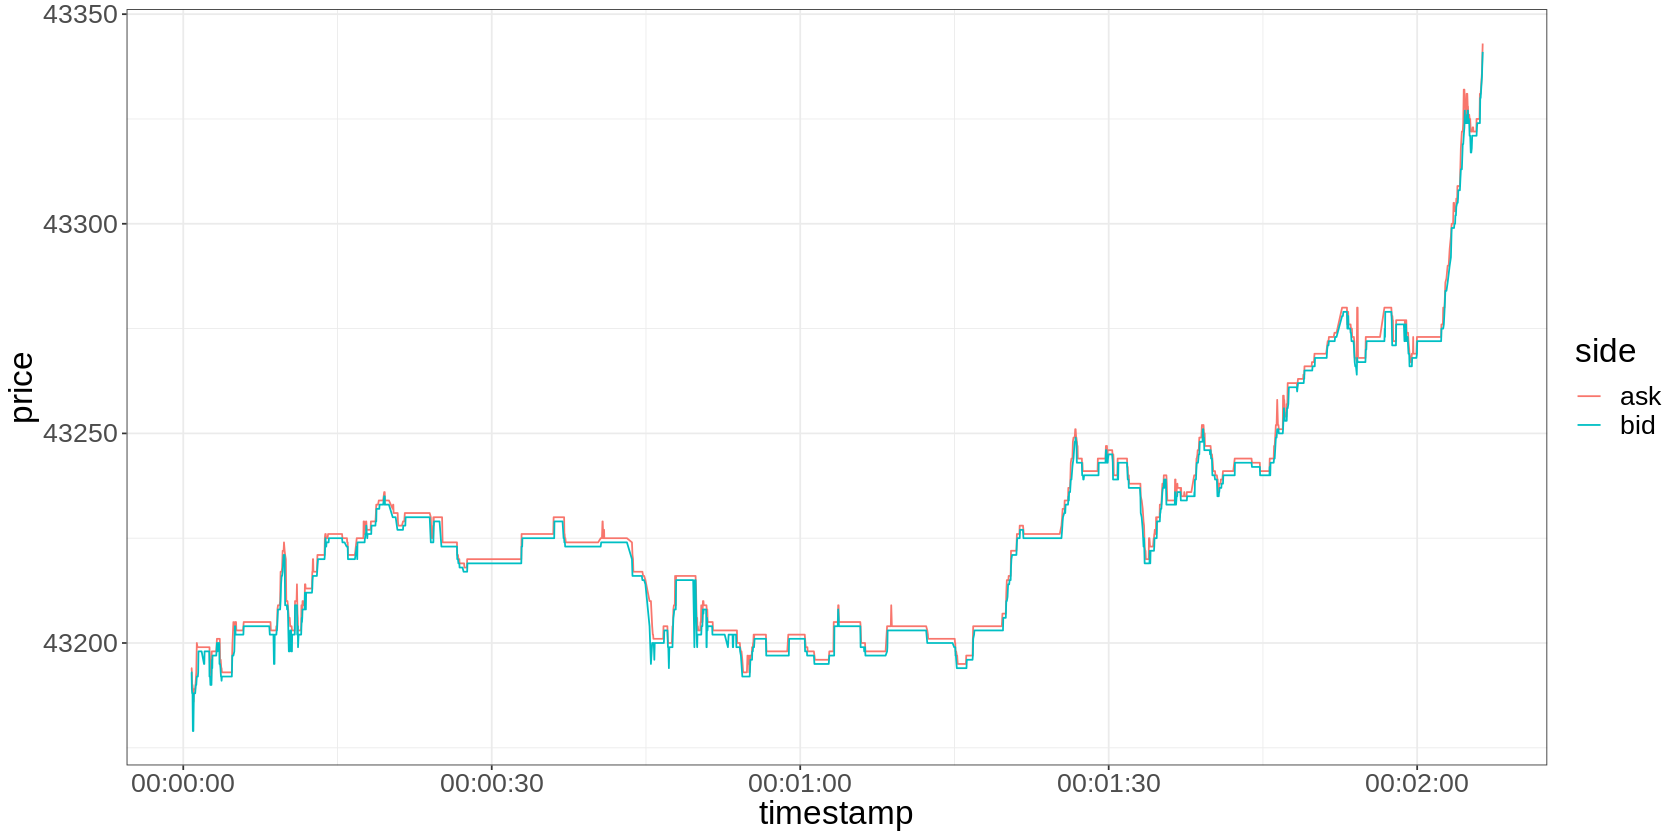

In [4]:
bbo %>%
  head(2500) %>% 
  pivot_longer(cols = c(ask_price, bid_price), names_to = 'side', values_to = 'price') %>%
  mutate(side = stringr::word(side, sep='_')) %>%
  ggplot(aes(x=timestamp, y=price, colour=side)) +
    geom_line()


How many records do we have?

In [5]:
bbo %>% nrow()

[1] 4157110

We want to mark trades to the midpoint 1 minute later.

Let's deal in ticks for now, cos it's easier.

On average, how many ticks in a minute?

In [6]:
bbo %>% 
  mutate(minutes = lubridate::floor_date(timestamp, 'minute')) %>%
  group_by(minutes) %>%
  summarize(n()) %>% 
  head()

minutes,n()
<dttm>,<int>
2022-03-01 00:00:00,1098
2022-03-01 00:01:00,1279
2022-03-01 00:02:00,1362
2022-03-01 00:03:00,1486
2022-03-01 00:04:00,1491
2022-03-01 00:05:00,1254


About 1000 ticks so let's use that.

Imagine for now that we can buy at the ask or the bid. (We can't but bear with me.)

We'd expect to make -0.5 * bid/ask trading at the ask and 0.5 * bid/ask trading at the bid.

In [7]:
markouts  <- bbo %>%
  arrange(timestamp) %>%
  mutate(
    bidask = (ask_price / bid_price - 1) * 100,
    mid_price = (bid_price + ask_price) / 2,
    mid_1000 = lead(mid_price, 1000),
    markout_mid = log(mid_1000 / mid_price) * 100,
    markout_bid = log(mid_1000 / bid_price) * 100,
    markout_ask = log(mid_1000 / ask_price) * 100
  ) %>% 
  na.omit()

markouts %>% head()

symbol,timestamp,ask_amount,ask_price,bid_price,bid_amount,bidask,mid_price,mid_1000,markout_mid,markout_bid,markout_ask
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BTC-PERP,2022-03-01 00:00:00,0.6911,43194,43193,0.5710,0.002315190,43193.5,43196.5,0.006945248,0.008102837,0.005787673
BTC-PERP,2022-03-01 00:00:00,1.1411,43194,43193,0.2000,0.002315190,43193.5,43194.0,0.001157575,0.002315163,0.000000000
BTC-PERP,2022-03-01 00:00:00,0.1727,43193,43189,0.3650,0.009261618,43191.0,43192.5,0.003472885,0.008103587,-0.001157602
BTC-PERP,2022-03-01 00:00:00,0.7359,43190,43188,0.1000,0.004630916,43189.0,43192.5,0.008103587,0.010419018,0.005788209
BTC-PERP,2022-03-01 00:00:00,0.9454,43190,43188,0.1000,0.004630916,43189.0,43192.5,0.008103587,0.010419018,0.005788209
BTC-PERP,2022-03-01 00:00:00,1.2183,43189,43179,0.0042,0.023159406,43184.0,43194.5,0.024311605,0.035890638,0.012733913


What is the averages over the sample?

In [8]:
markouts %>%
  summarize(
    mid = mean(markout_mid),
    bid = mean(markout_bid),
    ask = mean(markout_ask),
    half_bidask = mean(bidask) / 2
  )

mid,bid,ask,half_bidask
<dbl>,<dbl>,<dbl>,<dbl>
-0.000418724,0.00107569,-0.001913095,0.001494435


On average price went down slightly during that period.

If you could trade costlessly at the bid, you'd have made money - unsurprisingly.

If you could trade costlessly on the ask, you'd have lost money too.

We can take the drift away

In [9]:
markouts %>%
  summarize(
    mid = mean(markout_mid),
    bid_less_drift = mean(markout_bid) - mid,
    ask_less_drift = mean(markout_ask) - mid,
    half_bidask = mean(bidask) / 2
  )

mid,bid_less_drift,ask_less_drift,half_bidask
<dbl>,<dbl>,<dbl>,<dbl>
-0.000418724,0.001494414,-0.001494371,0.001494435


And we see exactly what we expect.

# Now let's look at the trades.

You can't buy on the bid until someone wants to sell to you.

Let's see if the trades look different.

In [10]:
trades <- crypto_get_trades_sample()
trades %>% head()

[1] "Please Wait. This is a large dataset."


ℹ Downloading ftx_btc_perp_trades_sample.feather

✔ Saved ftx_btc_perp_trades_sample.feather to ftx/ftx_btc_perp_trades_sample.fe…





File successfully transferred


symbol,timestamp,id,side,price,amount
<chr>,<dttm>,<dbl>,<chr>,<dbl>,<dbl>
BTC-PERP,2022-03-01 00:00:00,3439320725,buy,43183,0.1600
BTC-PERP,2022-03-01 00:00:00,3439320726,buy,43183,0.2404
BTC-PERP,2022-03-01 00:00:00,3439320736,buy,43187,0.2000
BTC-PERP,2022-03-01 00:00:00,3439320737,buy,43187,0.2000
BTC-PERP,2022-03-01 00:00:00,3439320738,buy,43187,0.2000
BTC-PERP,2022-03-01 00:00:00,3439320739,buy,43187,0.2000


We need to align trades to  1m ahead midprice, so let's calculate that first.

First sample to second resolution data.

Then lead the data 60 observations to get the mark 60 seconds later.

In [11]:
fwd_mid <- bbo %>% 
  mutate(
    timestamp_second = lubridate::floor_date(timestamp, 'second'),
    mid_price = (bid_price + ask_price) / 2,
  ) %>%
  group_by(timestamp_second) %>%
  summarize(mid = first(mid_price)) %>%
  arrange(timestamp_second) %>%
  mutate(fwd_mid = lead(mid, 60)) %>%
  na.omit()

fwd_mid %>% head()


timestamp_second,mid,fwd_mid
<dttm>,<dbl>,<dbl>
2022-03-01 00:00:00,43193.5,43201.5
2022-03-01 00:00:01,43184.5,43197.5
2022-03-01 00:00:02,43197.0,43195.5
2022-03-01 00:00:03,43197.5,43197.5
2022-03-01 00:00:04,43192.5,43204.5
2022-03-01 00:00:05,43204.5,43204.5


Now we join this to the passive buy trades

In [12]:
trades %>% 
  filter(side == 'sell') %>%
  mutate(timestamp_second = lubridate::floor_date(timestamp, 'second')) %>%
  inner_join(fwd_mid, by = 'timestamp_second') %>%
  mutate(pnl = log(fwd_mid / price) * 100) %>%
  summarize(mean_passive_pnl = mean(pnl))

mean_passive_pnl
<dbl>
-0.004845244


Best available maker rebate is -0.0030% - so you'd still lose money providing liquidity to every trade on the best tier.

And do the same for the aggressive buy trades

In [13]:
trades %>% 
  filter(side == 'buy') %>%
  mutate(timestamp_second = lubridate::floor_date(timestamp, 'second')) %>%
  inner_join(fwd_mid, by = 'timestamp_second') %>%
  mutate(pnl = log(fwd_mid / price) * 100) %>%
  summarize(mean_passive_pnl = mean(pnl))

mean_passive_pnl
<dbl>
0.007351205


Best general taker fee available is 0.04%. 

So you'd lose money doing both.